In [1]:
%matplotlib inline 

from imports import *

print('cuda' if torch.cuda.is_available() else 'cpu')

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe
cuda


# Code to Solve the Compressed-Sensing Magnetic Resonance Imaging (CS-MRI) Reconstruction Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{M} \odot (\boldsymbol{F} \boldsymbol{X} \boldsymbol{F} + \boldsymbol{\varepsilon}) , \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{X} \in \mathbb{R}^{n \times n}$: unknown image to recover 
- $\boldsymbol{F} \in \mathbb{C}^{n \times n}$: DFT matrix (https://en.wikipedia.org/wiki/DFT_matrix) 
- $\boldsymbol{M} \in \{0 ,1\}^{n \times n}$: 0-1 mask that denotes which Fourier coefficients are observed 
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{C}^{m}$: observed measurements (Fourier coefficients) 
- $ \odot : \mathbb{C}^{n_1 \times n_2} \times \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2}$: denotes the Kronecker product (https://en.wikipedia.org/wiki/Kronecker_product)


## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{X}}) = \frac{1}{2m} \| \boldsymbol{M} \odot (\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F}) \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{X}) := \frac{1}{m} \sum_{\{ i, j | y_{i, j} \not= 0 \}} \ell_{i,j}(\boldsymbol{X}) = \frac{1}{m}\sum_{\{ i, j | y_{i, j} \not= 0 \}} \frac{1}{2}(y_i - \boldsymbol{f}_i^\top \boldsymbol{X} \boldsymbol{f}_j)^2$

- $\boldsymbol{f}_i \in \mathbb{C}^m$: the $i^{\text{th}}$ column of the DFT matrix $\boldsymbol{F}$.


### Full gradient:

$\nabla \ell ({\boldsymbol{X}}) = \frac{1}{m}\boldsymbol{F}^\dagger \boldsymbol{M} \odot(\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F} ) \boldsymbol{F}^\dagger$

### Stochastic gradient:

$\nabla \ell_{i,j}({\boldsymbol{X}}) = (y_i - \boldsymbol{f}_j^\dagger \boldsymbol{X}^\dagger \boldsymbol{f}_i^\ast) \boldsymbol{f}_j^\dagger\boldsymbol{f}^\ast $

- $\dagger : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_2 \times n_1} $: Hermitian transpose
- $\ast : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2} $: Complex conjugate

In [2]:
network_type = 'DnCNN'
denoiser = Denoiser(net=eval(network_type)(17), 
                    experiment_name='exp1_flickr30k_' + network_type, 
                    data=False, sigma=30, batch_size=10)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


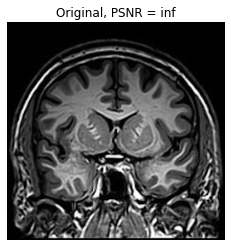

In [3]:
original = process_img('./data/Set12/13.jpg')['original']
noisy = process_img('./data/Set12/13.jpg')['noisy']

psnr_display('./data/Set12/13.jpg', original, "Original")

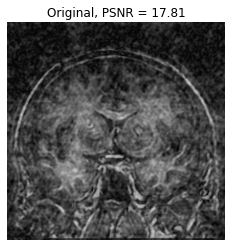

In [4]:
psnr_display('./data/Set12/13.jpg', noisy, "Original")

In [6]:
T1 = list(np.arange(0, 45, 5)[1:])
T2 = list(np.arange(0, 45, 5)[1:])
eta = list(np.arange(0.01, 0.1, 0.01))
# batch = list(range(10, 500, 100))
iters = list(product(T1, T2, eta))


'''
during cross-validation, only consider testing when T1 >= T2
'''
# pruned = []

# for each in iters:
#     if each[0] >= each[1]:
#         pruned.append(each)

'\nduring cross-validation, only consider testing when T1 >= T2\n'

In [ ]:
def f(iters):
    return peak_signal_noise_ratio(original, svrg(img_path='./data/Set12/13.jpg', 
                                                  denoiser=denoiser.net.cpu(),
                                                  eta=iters[2], T1=iters[0], T2=iters[1], 
                                                  batch_size=200)[0])

with MP.Pool(processes=5) as pool:
    results = list(tqdm.tqdm(pool.imap(f, pruned), total=len(pruned)))

In [ ]:
max(results), pruned[results.index(max(results))]

After denoising: 0 0 18.034766893645862
After denoising: 0 1 18.25788235209386
After denoising: 0 2 18.475848686320365
After denoising: 0 3 18.686688737701477
After denoising: 0 4 18.89100564111577
After denoising: 0 5 19.089012761610736
After denoising: 0 6 19.28011973704702
After denoising: 0 7 19.464333534409516
After denoising: 0 8 19.641702997023998
After denoising: 0 9 19.81114260236525
After denoising: 1 0 19.925251420882454
After denoising: 1 1 20.037809528791758
After denoising: 1 2 20.148759825068225
After denoising: 1 3 20.257530564277488
After denoising: 1 4 20.36402565839277
After denoising: 1 5 20.468241702905736
After denoising: 1 6 20.569244169184586
After denoising: 1 7 20.66755167519318
After denoising: 1 8 20.763214712478828
After denoising: 1 9 20.855947090706902
After denoising: 2 0 20.927305505182886
After denoising: 2 1 20.99764082229472
After denoising: 2 2 21.067017772770896
After denoising: 2 3 21.13522344176666
After denoising: 2 4 21.20228457388844
After den

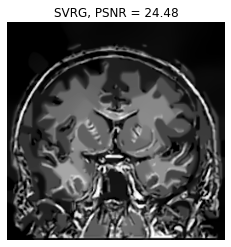

In [5]:
svrg_out, svrg_time, svrg_psnr, zs = svrg(img_path='./data/Set12/13.jpg', 
                                          denoiser='nlm', 
                                          eta=0.08, T1=20, T2=10, batch_size=200)
psnr_display('./data/Set12/13.jpg', svrg_out, "SVRG")

In [ ]:
svrg_out, svrg_time, svrg_psnr, zs = svrg(img_path='./data/Set12/13.jpg', 
                                       denoiser=denoiser.net, 
                                       eta=500, T1=1, T2=5000, batch_size=200)
psnr_display('./data/Set12/13.jpg', svrg_out, "SVRG")

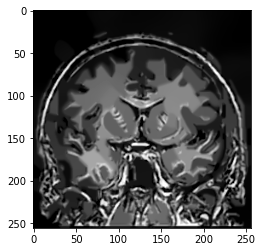

In [6]:
import ffmpeg
gif(zs)